[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.axes_style("whitegrid")

import scipy.integrate as integrate

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, binarize, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score  
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_validate

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Const And Global Vars

In [101]:
CORES = 3
CV_SPLIT = 10
model_dict = {}

# Declare funcs

In [3]:
def paint():
    tmp = train_df.groupby('label').sum()
    train_data = np.array(tmp, dtype='float32')

    first_image = train_data[0]

    first_image = np.array(first_image, dtype='uint8')
    pixels = first_image.reshape((28, 28))
    import numpy as np; np.random.seed(0)

    import seaborn as sns; sns.set()

    # uniform_data = np.random.rand(10, 12)
    uniform_data = pixels#//500
    ax = sns.heatmap(uniform_data)

    uniform_data.max()

In [54]:
def evaluate(true, pred, plot=False):
#     model_accuracy = roc_auc_score(true, pred, multi_class="ovr")
#     null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
#     print("Null AUC Score: {:.5f}".format(null_accuracy))
#     print("Model AUC Score: {:.5f}".format(model_accuracy))

#     if null_accuracy >= model_accuracy:
#         print("The model isn't effective")
# #         return
#     else:
#         print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))
    print('f1 score {}'.format(f1_score(true, pred, average='weighted')))
    print('accuracy score {}'.format(accuracy_score(true, pred)))
    if plot:
        plot_scores(true, pred)

In [49]:
def plot_scores(true, pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    labels = np.unique(true)

    ytest = label_binarize(true, classes=labels)
    ypreds = label_binarize(pred, classes=labels)

    n_classes = len(labels)
    f1_scores = dict()
    accuracy_scores = dict()
    for i in range(n_classes):
        f1_scores[i] = f1_score(ytest[:, i], ypreds[:, i], average='weighted')
        accuracy_scores[i] = accuracy_score(ytest[:, i], ypreds[:, i])
        plt.scatter(f1_scores[i], accuracy_scores[i], lw=2, label='class {}'.format(i))
#         plt.plot(f1_scores[i], accuracy_scores[i], lw=2, label='class {}'.format(i))
#     precision = dict()
#     recall = dict()
#     for i in range(n_classes):
#         precision[i] = precision_score(ytest[:, i], ypreds[:, i], average='weighted')
#         recall[i] = recall_score(ytest[:, i], ypreds[:, i], average='weighted')


    x = list(f1_scores.values())
    y = list(accuracy_scores.values())
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")
    print("y=%.6fx+(%.6f)"%(z[0],z[1]))
    integrate_score = (integrate.quad(lambda x: x-(z[0]*x+z[1]), 0, 1)[0])
    print('integrate score is {}'.format(integrate_score))
    
    plt.xlabel("f1_scores")
    plt.ylabel("accuracy_scores")
    plt.legend(loc="best")
    plt.title("f1_scores vs. accuracy_scores")
    plt.show()
    print(labels)
    print(accuracy_scores)
    print(f1_scores)
    return f1_scores

In [6]:
def score_models(model, model_scores):
    model_dict.update({model: model_scores})

    print("Accuracy: {:.2f} (+/- {:.2f})".format(model_scores['test_score'].mean(), model_scores['test_score'].std() * 2))
    print('Train time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['fit_time'].mean(), model_scores['fit_time'].std() * 2, model_scores['fit_time'].sum()))
    print('Test time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['score_time'].mean(), model_scores['score_time'].std() * 2, model_scores['score_time'].sum()))

In [7]:
def find_best_model():
    max_score = 0
    best_key = None
    for key in model_dict:
        model_score=model_dict[key]['test_score'].mean()
#         model_score = model_dict[key].mean()
#         try:   
#             model_score=model_dict[key]['test_score'].mean()
#         except IndexError: # remove this
#             model_score=model_dict[key].mean()
        if max_score < model_score:
            max_score = model_score
            best_key = key
    best_model_name = best_key
    print('the best model is {}'.format(best_key).split('(')[0], end = ' ')
    print('with the score of {}'.format(max_score))
    return best_key, max_score

---
# Data preparation

## load data

In [8]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

In [9]:
train_df.head()
train_df.isnull().sum().unique()

array([0], dtype=int64)

0 is t shirt\
1 is trousers\
2 is pullover\
3 is dress\
4 is coat\
5 is sandals\
6 is shirt\
7 is sneaker\
8 is bag\
9 is ankle boots

In [10]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [11]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


## split the training data into train and validate

In [12]:
train_data = np.array(train_df, dtype='float32')
test_data = np.array(test_df, dtype='float32')

X_train = train_data[:, 1:] / 1
y_train = train_data[:, 0]

X_test = test_data[:, 1:] / 1#/128#/255
y_test = test_data[:, 0]

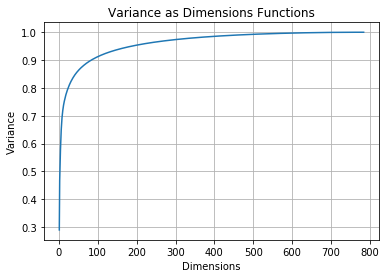

In [13]:
pca = PCA(random_state=0)
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.grid(True)
plt.title('Variance as Dimensions Functions')
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.show()

In [14]:
pca = PCA(random_state=0, n_components=0.90)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
d = len(pca.singular_values_)
print('the number of vectors after pca is {}'.format(d))

the number of vectors after pca is 84


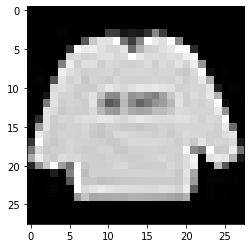

In [15]:
first_image = X_train[0]

first_image = np.array(first_image, dtype='uint8')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

---
# Models

## Run The Models

### Naive Bayes

Accuracy: 0.77 (+/- 0.01)
Train time: 0.08 seconds (+/- 0.02) for a total of 0.79 seconds
Test time: 0.08 seconds (+/- 0.01) for a total of 0.82 seconds
confusion_matrix:
 [[4562    1  122  401   21   32  443    0  416    2]
 [  32 5455  101  251   11    9   72    0   69    0]
 [  94    0 3820   38  768   41  905    0  333    1]
 [ 387   43   60 4840  192   27  308    0  143    0]
 [  36    3  638  299 3964   11  871    1  177    0]
 [  15    0    0    2    1 4656  122  892  217   95]
 [1021    2  679  213  474   29 3080    1  501    0]
 [   3    0    0    0    0  323   17 5262   18  377]
 [  60    0   41   50   52  127  223  165 5275    7]
 [   4    0    0    0    0  110   30  415   74 5367]]
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75      6000
         1.0       0.99      0.91      0.95      6000
         2.0       0.70      0.64      0.67      6000
         3.0       0.79      0.81      0.80      6000
         4.0       0.72   

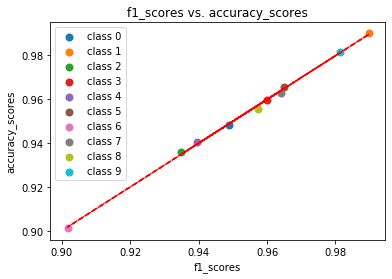

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9485, 1: 0.9901, 2: 0.9363166666666667, 3: 0.9597666666666667, 4: 0.94075, 5: 0.9657833333333333, 6: 0.9014833333333333, 7: 0.9631333333333333, 8: 0.95545, 9: 0.9814166666666667}
{0: 0.948900038149995, 1: 0.9899092079870554, 2: 0.9349773075173896, 3: 0.9599054982322028, 4: 0.9395573316545519, 5: 0.9649274370593732, 6: 0.9017406601351745, 7: 0.9640720945119391, 8: 0.9572550898242034, 9: 0.981311229521987}


In [57]:
gnb = GaussianNB()

# gnb.fit(X_train_pca, y_train)
# predictions = gnb.predict(X_test_pca)
# evaluate(y_test, predictions)

gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=10, return_estimator=True)
score_models(gnb, gnb_scores)

pred = cross_val_predict(gnb, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

In [61]:
gnb_scores['estimator']
for idx,estimator in enumerate(gnb_scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = diabetes.feature_names,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:


AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

In [17]:
# mnb = MultinomialNB()
# mnb.fit(X_train_pca, y_train)
# predictions = mnb.predict(X_test_pca)
# evaluate(y_test, predictions)

### Random Forest

In [60]:
rf = RandomForestClassifier(random_state=0, max_depth=None, n_estimators=100, n_jobs=CORES)

# scores = cross_val_score(rf, X_train_pca, y_train, cv=10, scoring='neg_mean_squared_error')
# rf_score = np.sqrt(-scores)
rf_scores = cross_validate(rf, X_train_pca, y_train, cv=10, n_jobs=CORES, return_estimator=True)


score_models(rf, rf_scores)

pred = cross_val_predict(rf, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)
# rf_scores['estimator']

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                        oob_score=False, random_state=0, verbose=0,
                        warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
           

In [110]:
predictions = np.array([])
size = len(y_train)
split = size//CV_SPLIT
X_cv_split = np.arange(0, size+1, split)
# print(X_cv_split)
index = 0
for idx,estimator in enumerate(rf_scores['estimator']):
#     print("Features sorted by their score for estimator {}:".format(idx))
#     feature_importances = pd.DataFrame(estimator.feature_importances_,
#                                        index = test_df.columns[1:],
#                                         columns=['importance']).sort_values('importance', ascending=False)
#     print(feature_importances)

#     print(estimator.feature_importances_)
#     print(estimator.base_estimator_)
#     print(len(estimator.estimators_))
#     print(estimator.classes_)
#     print(estimator.n_classes_)
#     print(estimator.n_features_)
#     print(estimator.n_outputs_)
#     print(estimator.oob_score_)

    predictions = np.append(predictions, estimator.predict(X_train_pca[X_cv_split[index]:X_cv_split[index+1]]))
#     print(predictions)
    index = index+1
evaluate(y_train, predictions)
# from sklearn import datasets
# dbdf = datasets.load_diabetes()
# test_df.columns[1:]

confusion_matrix:
 [[5160    6   97  205   25   10  433    0   63    1]
 [  17 5757   34  154   12    0   21    0    4    1]
 [  59    2 4919   52  570    6  342    0   49    1]
 [ 169   22   43 5409  177    2  145    0   32    1]
 [  14    4  520  223 4893    2  297    0   47    0]
 [   0    0    0    4    0 5656    0  191   22  127]
 [ 940    6  673  138  524   11 3608    0  100    0]
 [   0    0    0    0    0  207    0 5530    7  256]
 [  13    1   22   35   24   74   53   23 5744   11]
 [   0    0    0    0    1  107    0  198    3 5691]]
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83      6000
         1.0       0.99      0.96      0.98      6000
         2.0       0.78      0.82      0.80      6000
         3.0       0.87      0.90      0.89      6000
         4.0       0.79      0.82      0.80      6000
         5.0       0.93      0.94      0.94      6000
         6.0       0.74      0.60      0.66      6000
         7.0     

### KNN

#### find the optimum K 

In [19]:
k_max = 15
k_min = 1
err_rate = []
for i in range(k_min, k_max+1):
    k = KNeighborsClassifier(n_neighbors=i, n_jobs=CORES)
#     k.fit(X_train_pca, y_train)
#     pred_i = k.predict(X_test_pca)
#     err_rate.append(np.mean(pred_i != y_test))
    scores = cross_validate(k, X_train_pca, y_train, cv=10, n_jobs=CORES)['test_score']
    if scores.std() > 0.5:
        err_rate.append(0)
    else:
        err_rate.append(scores.mean())

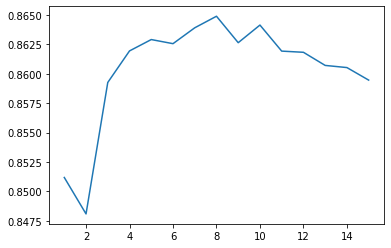

In [20]:
plt.plot(np.arange(k_min, k_max+1), err_rate)
plt.show()

In [21]:
index = err_rate.index(max(err_rate)) + 1
index

8

Accuracy: 0.86 (+/- 0.01)
Train time: 2.16 seconds (+/- 0.44) for a total of 21.56 seconds
Test time: 20.14 seconds (+/- 8.83) for a total of 201.40 seconds
confusion_matrix:
 [[5260    2   86  134   38    1  426    1   50    2]
 [  29 5801   22  109    9    0   25    0    4    1]
 [  94    5 4786   49  630    1  415    1   19    0]
 [ 217   28   41 5331  232    0  136    0   15    0]
 [  23    8  613  222 4680    0  436    0   18    0]
 [   3    0    0    2    0 5417    5  310   19  244]
 [1164    8  730  102  498    0 3436    0   61    1]
 [   0    0    0    0    0   71    0 5692    1  236]
 [  21    1   53   33   36    9   46   25 5768    8]
 [   0    0    2    0    0   34    1  238    2 5723]]
              precision    recall  f1-score   support

         0.0       0.77      0.88      0.82      6000
         1.0       0.99      0.97      0.98      6000
         2.0       0.76      0.80      0.78      6000
         3.0       0.89      0.89      0.89      6000
         4.0       0.7

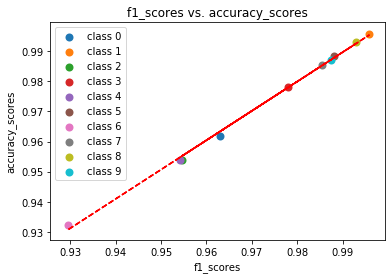

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9618166666666667, 1: 0.9958166666666667, 2: 0.9539833333333333, 3: 0.978, 4: 0.95395, 5: 0.98835, 6: 0.9324333333333333, 7: 0.9852833333333333, 8: 0.9929833333333333, 9: 0.9871833333333333}
{0: 0.9628808151164308, 1: 0.9957935690974834, 2: 0.9545334133470631, 3: 0.977985308240648, 4: 0.9541573589140632, 5: 0.9881392104755505, 6: 0.929445159917781, 7: 0.9854252561840876, 8: 0.9929721128760718, 9: 0.9872833456166082}


In [22]:
k = KNeighborsClassifier(n_neighbors=index, n_jobs=CORES)
k_scores = cross_validate(k, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(k, k_scores)

pred = cross_val_predict(k, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### Logistic Regression

Accuracy: 0.84 (+/- 0.01)
Train time: 17.08 seconds (+/- 5.24) for a total of 170.84 seconds
Test time: 0.01 seconds (+/- 0.00) for a total of 0.10 seconds
confusion_matrix:
 [[4962   18  101  302   36   16  488    9   63    5]
 [  25 5764   29  136   17    1   24    2    2    0]
 [  90   25 4378   69  805   19  557    6   49    2]
 [ 226   74   65 5183  219    4  194    4   26    5]
 [  13   12  558  237 4543    4  599    2   32    0]
 [   6    0    0    3    1 5552    3  294   42   99]
 [ 925   16  672  212  641   10 3393    7  121    3]
 [   0    0    0    0    0  243    1 5517   14  225]
 [  28    8   39   57   20   55  127   40 5610   16]
 [   0    1    0    1    0  100    1  218    4 5675]]
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81      6000
         1.0       0.97      0.96      0.97      6000
         2.0       0.75      0.73      0.74      6000
         3.0       0.84      0.86      0.85      6000
         4.0       0.72

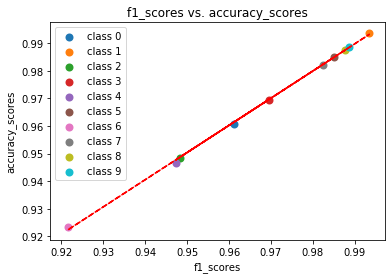

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9608166666666667, 1: 0.9935, 2: 0.9485666666666667, 3: 0.9694333333333334, 4: 0.9467333333333333, 5: 0.985, 6: 0.9233166666666667, 7: 0.98225, 8: 0.9876166666666667, 9: 0.9886666666666667}
{0: 0.9612055703049412, 1: 0.993480104586053, 2: 0.9482611137061242, 3: 0.9696555248030659, 4: 0.947275121464863, 5: 0.9850022213788782, 6: 0.9214690037166474, 7: 0.9823144767570123, 8: 0.9875996371412259, 9: 0.9886792234935493}


In [23]:
lr = LogisticRegression(random_state=0, n_jobs=CORES)#, solver='lbfgs', penalty='l2')
lr_scores = cross_validate(lr, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(lr, lr_scores)

pred = cross_val_predict(lr, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### SVM

#### SVC

Accuracy: 0.79 (+/- 0.02)
Train time: 113.52 seconds (+/- 36.53) for a total of 1135.17 seconds
Test time: 16.19 seconds (+/- 5.95) for a total of 161.89 seconds
confusion_matrix:
 [[3568    7   62  283   17    3 2017    0   42    1]
 [  15 5799   13  135    7    0   27    0    3    1]
 [ 142    4 2909   64  936    2 1919    0   24    0]
 [  90   26   97 5362   78    0  327    0   20    0]
 [  23    8  753  479 2992    0 1729    0   16    0]
 [   3    0    0    2    0 5465    1  457   17   55]
 [ 799   10  435  191  627    1 3874    0   63    0]
 [   0    0    0    0    0   53    0 5579    9  359]
 [  18    1   30   25   25    9   40   18 5832    2]
 [   1    0    0    1    0   60    0  121    3 5814]]
              precision    recall  f1-score   support

         0.0       0.77      0.59      0.67      6000
         1.0       0.99      0.97      0.98      6000
         2.0       0.68      0.48      0.56      6000
         3.0       0.82      0.89      0.86      6000
         4.0     

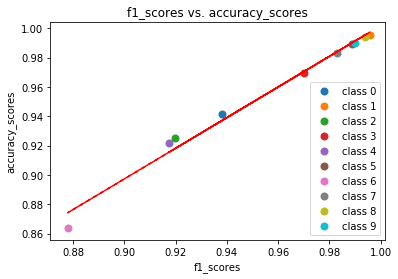

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9412833333333334, 1: 0.9957166666666667, 2: 0.9253166666666667, 3: 0.9697, 4: 0.9217, 5: 0.98895, 6: 0.8635666666666667, 7: 0.98305, 8: 0.9939166666666667, 9: 0.9899333333333333}
{0: 0.9379498474978311, 1: 0.995693343202094, 2: 0.9197282665959483, 3: 0.9702782901530739, 4: 0.9173414866817766, 5: 0.9887767745518661, 6: 0.8778301237902603, 7: 0.983158062321495, 8: 0.9939231826765627, 9: 0.9900179631569577}


In [24]:
svc = SVC(random_state=0, max_iter=500)

svc_scores = cross_validate(svc, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(svc, svc_scores)

pred = cross_val_predict(svc, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### Decision Tree

Accuracy: 0.77 (+/- 0.01)
Train time: 12.85 seconds (+/- 0.43) for a total of 128.53 seconds
Test time: 0.00 seconds (+/- 0.00) for a total of 0.03 seconds
confusion_matrix:
 [[4347   72  152  328   68   18  923    2   87    3]
 [  68 5612   45  167   39    3   53    0   12    1]
 [ 144   31 3887  107  904   19  801    1  103    3]
 [ 335  180  113 4649  301   13  327    1   79    2]
 [  82   31  875  302 3859    7  756    2   83    3]
 [  20    2   16   11   13 5040   16  507   99  276]
 [ 924   50  808  261  736   13 3059    4  143    2]
 [   1    1    3    1    1  476    3 5060   46  408]
 [  82   14  114   72   94  115  189   41 5264   15]
 [   6    2    2    2    0  223    4  405   22 5334]]
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72      6000
         1.0       0.94      0.94      0.94      6000
         2.0       0.65      0.65      0.65      6000
         3.0       0.79      0.77      0.78      6000
         4.0       0.64

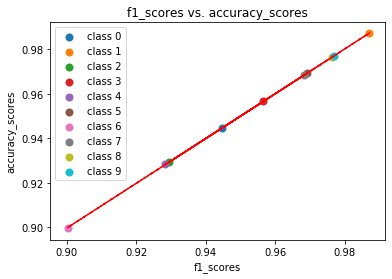

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.94475, 1: 0.98715, 2: 0.9293166666666667, 3: 0.9566333333333333, 4: 0.9283833333333333, 5: 0.9692166666666666, 6: 0.8997833333333334, 7: 0.9682833333333334, 8: 0.9765, 9: 0.9770166666666666}
{0: 0.9447684009473934, 1: 0.9871476192406836, 2: 0.9293558793509316, 3: 0.9564711790359067, 4: 0.9284230637988572, 5: 0.9691328575421708, 6: 0.9002635888350755, 7: 0.9683102923692849, 8: 0.9764457178782027, 9: 0.9770564969164465}


In [25]:
dtc = DecisionTreeClassifier(random_state=0)
dtc_scores = cross_validate(dtc, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(dtc, dtc_scores)

pred = cross_val_predict(dtc, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### Gradient Boosting

In [26]:
# gb = GradientBoostingClassifier(random_state=0)
# gb_scores = cross_validate(gb, X_train_pca, y_train, cv=10, n_jobs=CORES)
# score_models(gb, gb_scores)

# pred = cross_val_predict(gb, X_train_pca, y_train, cv=10, n_jobs=CORES)
# evaluate(y_train, pred, plot=True)

## Find Best Model

In [27]:
best_model, best_model_score = find_best_model()

the best model is RandomForestClassifier with the score of 0.8675


## Improve The Model

### Ada Boost

confusion_matrix:
 [[5162    5   93  213   25   12  422    0   67    1]
 [  20 5740   36  158   12    0   27    0    6    1]
 [  55    1 4861   55  614    9  354    0   51    0]
 [ 162   23   45 5413  189    3  136    0   28    1]
 [  11    5  508  226 4856    4  346    0   44    0]
 [   0    0    0    4    0 5633    0  217   18  128]
 [ 995    5  718  151  535    9 3479    0  108    0]
 [   0    0    0    0    0  207    0 5525    5  263]
 [  13    0   34   37   27   66   45   25 5742   11]
 [   0    0    1    0    0  111    0  204    3 5681]]
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      6000
         1.0       0.99      0.96      0.97      6000
         2.0       0.77      0.81      0.79      6000
         3.0       0.87      0.90      0.88      6000
         4.0       0.78      0.81      0.79      6000
         5.0       0.93      0.94      0.93      6000
         6.0       0.72      0.58      0.64      6000
         7.0     

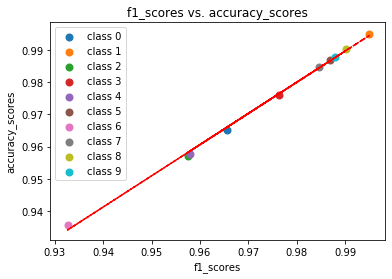

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9651, 1: 0.9950166666666667, 2: 0.9571, 3: 0.97615, 4: 0.9575666666666667, 5: 0.9868666666666667, 6: 0.9358166666666666, 7: 0.98465, 8: 0.9902, 9: 0.9879333333333333}
{0: 0.965619580845281, 1: 0.9949750057847114, 2: 0.9575574125880851, 3: 0.9763715939820112, 4: 0.9579624183887083, 5: 0.9868927993115523, 6: 0.9326306553001198, 7: 0.9846334674770076, 8: 0.9902259558061903, 9: 0.9879714563988139}


In [29]:
base_estimetor = best_model
adb = AdaBoostClassifier(base_estimetor, random_state=0)
adb_scores = cross_validate(adb, X_train_pca, y_train, cv=10, n_jobs=CORES)

pred = cross_val_predict(adb, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

#### check if the model was improved

In [30]:
if adb_scores['test_score'].mean() > best_model_score:
    best_model = adb

## Test The Model On The Test Data

confusion_matrix:
 [[857   0  19  36   3   3  70   0  12   0]
 [  4 963   8  19   2   0   4   0   0   0]
 [ 12   0 802   7 105   1  61   0  12   0]
 [ 26   6  11 909  24   1  19   0   4   0]
 [  1   1  66  26 850   0  50   0   6   0]
 [  1   0   0   1   0 917   0  52   5  24]
 [178   2 104  26  83   1 591   0  15   0]
 [  0   0   0   0   0  39   0 903   0  58]
 [  2   0   6   4   3  10   5   4 965   1]
 [  0   0   0   0   0  16   0  39   0 945]]
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82      1000
         1.0       0.99      0.96      0.98      1000
         2.0       0.79      0.80      0.80      1000
         3.0       0.88      0.91      0.90      1000
         4.0       0.79      0.85      0.82      1000
         5.0       0.93      0.92      0.92      1000
         6.0       0.74      0.59      0.66      1000
         7.0       0.90      0.90      0.90      1000
         8.0       0.95      0.96      0.96      1000
         

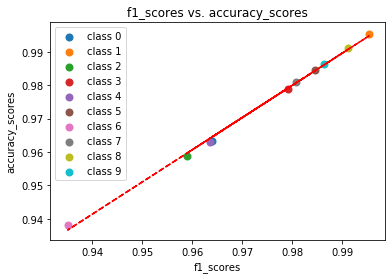

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9633, 1: 0.9954, 2: 0.9588, 3: 0.979, 4: 0.963, 5: 0.9846, 6: 0.9382, 7: 0.9808, 8: 0.9911, 9: 0.9862}
{0: 0.9639312996905103, 1: 0.9953709150201783, 2: 0.9589451646613568, 3: 0.9791286116338762, 4: 0.9635533785440428, 5: 0.9845586510401517, 6: 0.935106227106227, 7: 0.9807914569385517, 8: 0.9911371749812738, 9: 0.9862845162165471}


In [31]:
best_model.fit(X_train_pca, y_train)
predictions = best_model.predict(X_test_pca)
evaluate(y_test, predictions, plot=True)

### run without pca

In [ ]:
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
evaluate(y_test, predictions)

In [ ]:
# from sklearn.preprocessing import label_binarize

# labels = [0, 1, 2, 3,4,5,6,7,8,9]
# ytest = label_binarize(y_test, classes=labels)
# ypreds = label_binarize(predictions, classes=labels)

# roc_auc_score(ytest, ypreds, average='macro',multi_class='ovo')
# # plot_roc_curve(best_model, X_test_pca, y_test)

In [ ]:
# # precision recall curve
# # precision = dict()
# # recall = dict()
# # for i in range(n_classes):
# #     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
# #                                                         y_score[:, i]))
# #     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
# n_classes = len(labels)
# roc_scores = [0, 1, 2, 3,4,5,6,7,8,9]
# for i in range(n_classes):
#     roc_scores[i] = roc_auc_score(ytest[:, i], ypreds[:, i], average='macro',multi_class='ovo')
#     plt.scatter(labels[i], roc_scores[i], lw=2, label='class {}'.format(i))

# # plt.plot(labels, roc_scores, lw=2, label='class {}'.format(i))
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.legend(loc="best")
# plt.title("precision vs. recall curve")
# plt.show()

# for i in range(n_classes):
#     print('{} {}'.format(labels[i], roc_scores[i]))

In [ ]:
# gnb = GaussianNB()
# # 
# # gnb.fit(X_train_pca, y_train)
# # predictions = gnb.predict(X_test_pca)
# # evaluate(y_test, predictions)

# gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=10)
# score_models('GaussianNB', gnb_scores)

# pred = cross_val_predict(gnb, X_train_pca, y_train, cv=10, n_jobs=CORES)

# print(accuracy_score(y_train, pred))

# evaluate(y_train, pred, plot=True)
# # print(f1_score(y_train, pred, average='macro'))

# # tmp = plot_scores(y_train, pred)
# # tmp

In [ ]:
# evaluate(y_test, predictions)

# ytest = label_binarize(y_test, classes=labels)
# ypreds = label_binarize(predictions, classes=labels)

# # scoring = 'average_precision'
# fpr, tpr, thresholds = roc_curve(ytest, ypreds)
# scores = []
# for x in thresholds:
#     predictions_class = binarize([predictions], x)[0]
#     scores.append(average_precision_score(y_test, predictions_class))
# scores = np.array(scores)
# index = np.argmax(scores) 


# scores = []
# thresholds = np.arange(0, 1, 0.01)
# for x in thresholds:
#     predictions_class = binarize([predictions], x)[0]
#     scores.append(accuracy_score(y_test, predictions_class))
# scores = np.array(scores)
# index = np.argmax(scores) 
# predictions_class = binarize([predictions], thresholds[index])[0]
# evaluate(y_test, predictions_class)


# thresholds[index]
# predictions
# # binarize([predictions], 0.5)[0]
# y_test

In [ ]:
# ### Predict test_y values and probabilities based on fitted logistic 
# # regression model

# pred_y=best_model.predict(X_test_pca) 
# # pred_y = predictions

# probs_y=best_model.predict_proba(X_test_pca) 
# #   # probs_y is a 2-D array of probability of being labeled as 0 (first 
# #   column of 
# #   array) vs 1 (2nd column in array)

# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
# 1]) 
#    #retrieve probability of being 1(in second column of probs_y)
# pr_auc = metrics.auc(recall, precision)

# plt.title("Precision-Recall vs Threshold Chart")
# plt.plot(thresholds, precision[: -1], "b--", label="Precision")
# plt.plot(thresholds, recall[: -1], "r--", label="Recall")
# plt.ylabel("Precision, Recall")
# plt.xlabel("Threshold")
# plt.legend(loc="lower left")
# plt.ylim([0,1])

In [47]:
import scipy.integrate as integrate
'y=0.964733x+(0.034505)'
# func = 0.964733x+(0.034505)
integrate.quad(lambda x: x-(0.964733*x+(0.034505)), 0, 1)[0]

-0.016871499999999994